# Introduction

My master thesis looked into service discovery recommendation system research based on data available at the programmable web [website](https://www.programmableweb.com/). 

In this notebook, I will share some of what I learned and use Latent Dirichlet Allocation and the Author Topic Model are implemented and the results were compared in terms of Mean Average Precision@N and Recall@N.

!['Welcome APIs'](https://i.imgur.com/rPh0kkS.jpg)

## Importing Libraries and Loading Data 

In [1]:
import numpy as np
import pandas as pd
import re
from collections import  Counter
import ml_metrics as metrics
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#Mashup Data 
mdata = pd.read_csv("data/mashups_2k18.csv",sep='\t',encoding='utf-8')
#list of unique APIs
u_apis= pd.read_csv("data/unique_apis.csv",sep='\t',encoding='utf-8')
mdata.sort_values('title',inplace=True)
u_apis.sort_values('api_name',inplace=True)
print('Total Number of Mashups: ', mdata.shape[0])
print('Total Number of Mashups: ', u_apis.shape[0])

mdata.head()


Total Number of Mashups:  6962
Total Number of Mashups:  1520


,Unnamed: 0,description,title,date,Related_APIs,Tags
906,906,"#API Christmas is the Nativity Story, remixed ...",#API Christmas,2012-12-20,['instagram-graph'],"['aggregation', 'holidays', 'humor', 'social',..."
2486,2486,"#Ask4Stuff is a new, Twitter-based service tha...",#Ask4Stuff: WorldCat Twitter Search,2010-06-27,"['twitter', 'worldcat-search']","['library', 'search', 'books']"
610,610,To discover the most popular beer in over 1500...,"#BeerMap - The Top 2,500 Beers on Twitter",2013-09-19,"['google-maps', 'twitter', 'peekyou-social-ana...","['analytics', 'beer', 'humor']"
2922,2922,"Get some shiny stats about countries, cities a...",#LinS Stats on Your LinkedIn Social Graph,2009-11-27,"['google-chart', 'linkedin']","['social', 'statistics', 'social', 'enterprise']"
577,577,The #S42AT project lets you bookmark links you...,#S42AT,2013-11-11,"['facebook', 'twitter', 'instagram-graph', 'go...","['bookmarks', 'tools', 'tweets']"


In [2]:
adata.head()

,Unnamed: 0,categories,description,logo,progweb_specs,progweb_url,title,Tags
0,0,"/category/feeds, /category/customer-relationsh...",Finansportalen is a site provided by the Norwe...,http://www.programmableweb.comhttps://www.prog...,{'Secondary Categories': '/category/customer-r...,https://www.programmableweb.com/api/finansport...,Finansportalen API,"['feeds', 'customer-relationship-management']"
1,1,"/category/search, /category/marketing",SEMrush creates software products for search a...,http://www.programmableweb.comhttps://www.prog...,{'Secondary Categories': '/category/marketing'...,https://www.programmableweb.com/api/semrush,SEMrush API,"['search', 'marketing']"
2,2,"/category/government, /category/health",Healthfinder is an example of a government hea...,http://www.programmableweb.comhttps://www.prog...,"{'Secondary Categories': '/category/health', '...",https://www.programmableweb.com/api/healthfind...,Healthfinder.gov API,"['government', 'health']"
3,3,/category/authentication,The service registers uniform resource names (...,http://www.programmableweb.comhttps://www.prog...,{'Support Email Address': 'edugain-ot@geant.ne...,https://www.programmableweb.com/api/eduroam,eduroam API,['authentication']
4,4,"/category/advertising, /category/search",The Google AdWords API is the main revenue sou...,http://www.programmableweb.comhttps://www.prog...,"{'SSL Support': 'Yes', 'Secondary Categories':...",https://www.programmableweb.com/api/google-adw...,Google AdWords API,"['advertising', 'search']"


## Data Pre-processing

As machine learning models can not deal with raw text data, a set of pre- processing steps is needed to give a meaningful representation of the text. The text is transformed to a Bag-of-Words representation which assigns a unique number to every word in the vocabulary, this way any document can be represented as a vector of length $\vert V\vert$ the number of unique words in the vocabulary. Each cell in the vector contains the count of the word in the document. 
This can be done by assigning each word a unique number. Then any document we see can be encoded as a fixed-length vector with the length of the vocabulary of known words. The value in each position in the vector could be filled with a count or frequency of each word in the encoded document.

A high number of words generally translates into more computation and sparsity in the bag of word model, meaning that words should be carefully selected from the vocabulary and words that do not add meaning to the machine learning model should be dropped. The pre-processing steps follow the general guidelines of working with text in the Nature Language Processing field and the reviewed work on service discovery RS:

####  Tokenization: dividing a stream of text into a sequence of words according to a delimiter (space in this case)
#### Pruning: Removing words that do not add meaning to the sentence, also known as stop-words removal, a list of stopwords was taken from the Natural Language Toolkit (nltk) python library to this end
##### item Stemming: Stripping words from suffixes and/or prefixes to get to the word stem/root. This way word like 'map','mapping' and 'maps' would be counted as 'map' adding relevance for the model. The Porter Stemmer of the nltk library was used.
#### Text Augmentation: Since Mashup and API titles and categories add meaning to the representation of a mashup, they are added to the description of the mashups.




In [56]:
#storing the mashup corpus as a list of words
corpus_list=[]
#storing the corpus as strings
corpus_string = []
#APIs related to each row of the mashup data
rapis= []
#storing the API corpus as strings
corpus_api_string = []
#storing the API corpus as a list of word_ids
corpus_api_list = []
#dictionary for mashup and its corespending APIs
dict_mashup_apis = dict()
#Number of times each API was used in a mashup
api_count = []
#calculating tag counts for EDA
tag_count  = []
#mashup_api matrice for EDA
ma_matrice = np.zeros((mdata.shape[0],u_apis.shape[0]),dtype=int)


for i in range(0, mdata.shape[0]):
    
    # get each related api seperatly
    apis = list(filter(None,re.sub('[^\w+\d+-]',' ', mdata['Related_APIs'][i]).strip().split(' ')))
    rapis.append(apis)
    dict_mashup_apis[i] = []
    
    for a in apis:
        dict_mashup_apis[i].append(a)
        api_index = u_apis.loc[u_apis['api_name']==a].index
        ma_matrice[i][api_index]= ma_matrice[i][api_index] + 1
        
    api_count.extend(apis)
    
    #Extract Description and tags while removing special characters 
    review = re.sub('[^a-zA-Z-\d+]', ' ', mdata['description'][i])
    tags =  re.sub('[^a-zA-Z-\d+]',' ',mdata['Tags'][i])
    tag_count.extend(tags.split())
    review = review.lower()  
    review = review.split()
    #Changing each word to stem form
    ps = PorterStemmer()
    stopwords_ = list(set(stopwords.words('english')))
    stopwords_.append('mashup')
    review = [ps.stem(word) for word in review if not word in set(stopwords_)]
    #adding the tags 3 times and the title of the mashup to the mashup description 
    for j in range(3):
        review.append(tags)

    review.append(mdata['title'][i])
    corpus_list.append(review)
    review = ' '.join(review)
    corpus_string.append(review)
    

print(mdata['description'][10],'\n After Pre-processing')
corpus_string[10]


Goodneighbor is a platform that allows you to define, run and manage Twitter avatars, totally autonomous Twitter identities that manage their own Twitter accounts, concerned with any subject matter and interested in any topic. 
 After Pre-processing


'goodneighbor platform allow defin run manag twitter avatar total autonom twitter ident manag twitter account concern subject matter interest topic   artificial-intelligence    social     artificial-intelligence    social     artificial-intelligence    social   Goodneighbor'

So far we have tokenized and stemed the mashup and APIs description, and mapped each API (Parent) to its mashup (child).

Now let's change api names and words to numerical IDs, and create our bag of word model

In [4]:


# Changing API name to API ids
unique_apis = list(u_apis['api_name'])
api_id_dict = dict(zip(unique_apis, range(len(unique_apis))))
api_id_dict_reverse = dict(zip( range(len(unique_apis)),unique_apis))

#Create dictionary of Mashups and Related APIs IDs
for mash, rapi in dict_mashup_apis.items():
    for i, api_id in enumerate(rapi):
        
        dict_mashup_apis[mash][i] = api_id_dict[api_id]

# Let's create the bag of word model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df=5,max_df=0.8,stop_words='english')
L = cv.fit_transform(corpus_string + corpus_api_string).toarray()
features = cv.get_feature_names()

 


In [5]:
#Now let's encode the corpus with only the features extracted from the count vectorizer and create appropriate word dict
corpus_encoded = []
word_id_dict = dict(zip(features, range(len(features))))
word_id_dict_reverse = dict(zip( range(len(features)),features))
corpus_encoded = []
for each in corpus_list:
    words_encoded = []
    for e in each:
        if(e in word_id_dict):
            words_encoded.append(word_id_dict[e])
    corpus_encoded.append(words_encoded)

corpus_api_encoded = []
for each in corpus_api_list:
    words_encoded = []
    for e in each:
        if(e in word_id_dict):
            words_encoded.append(word_id_dict[e])
    corpus_api_encoded.append(words_encoded)

# EDA 

## What APIs are used the most for creating Mashups?

The first graph plots the API use count, and we can clearly see that very few APIs are responsible for most mashups. Leading the pack is 'google-maps' with more than 2300 mashup to its count, followed by Twitter that has more than 750 mashup.
On the other hand, the top 40 - 50 APIs are only used to create around 40 mashups





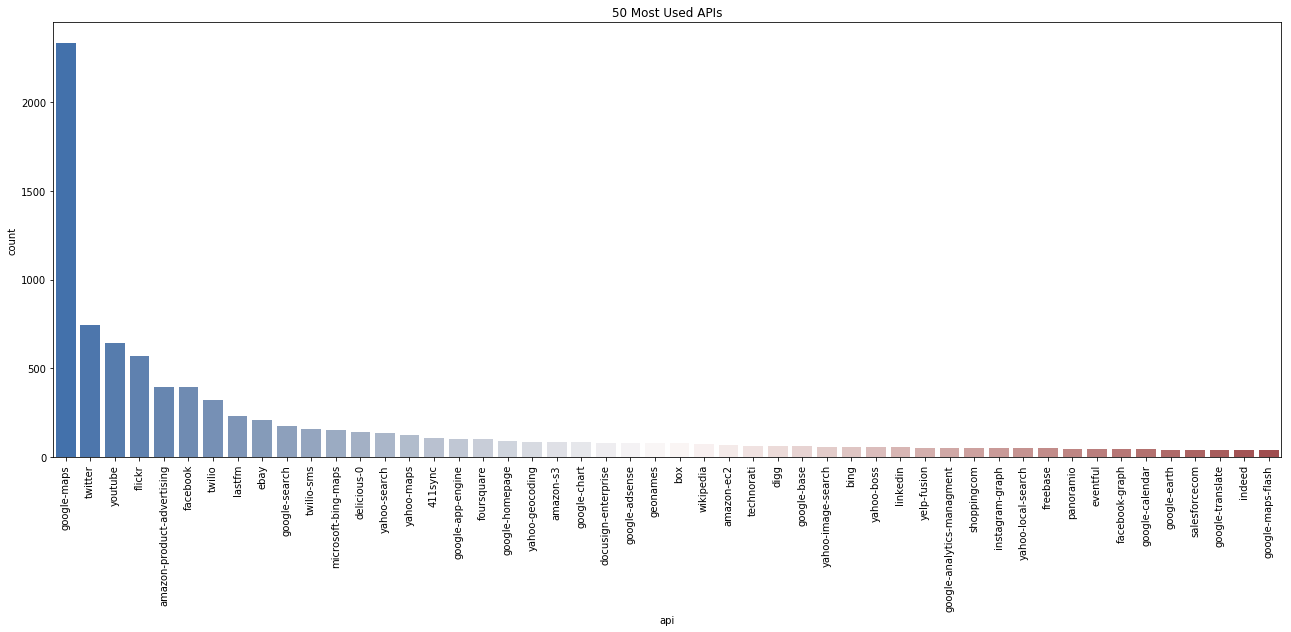

In [6]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

counter2 = Counter(api_count)
eda_apis =  pd.DataFrame.from_dict(counter2, orient='Index').reset_index()
eda_apis.columns = ['api','count']
f_apid = lambda x : api_id_dict[x]
eda_apis['id'] = eda_apis['api'].apply(f_apid)
eda_apis.sort_values('count',ascending=False,inplace=True)
top_50_apis = eda_apis[["count",'api']][:50].copy()


plt.subplots(figsize=(22, 8))
plt.xticks(rotation=90)
sns.barplot(x='api', y="count", data=top_50_apis, palette="vlag").set_title("50 Most Used APIs")
plt.show()






In [7]:
top_50_apis.tail(10)

,count,api
241,50,freebase
359,48,panoramio
83,47,eventful
341,44,facebook-graph
192,44,google-calendar
447,43,google-earth
279,43,salesforcecom
302,42,google-translate
53,41,indeed
555,40,google-maps-flash


## What are the most popular Tags ?

We can see from the graph that the tag distribution is similar to that of APIs (few tags present with most mashups) 
It is normal to see such distribution since the APIs used with a mashup influence the possible functionalities of the mashup (hence tags as well)


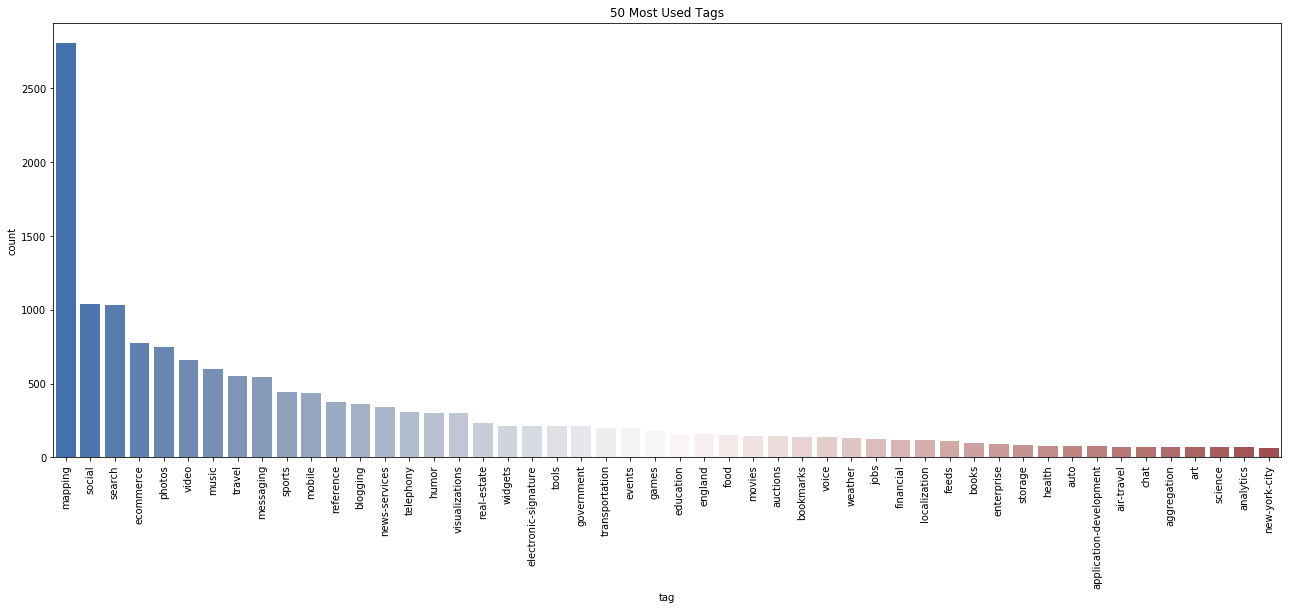

In [8]:
counter = Counter(tag_count)
tag_count_result= list(counter.most_common())
eda_tags = pd.DataFrame.from_dict(counter, orient='Index').reset_index()
eda_tags.columns = ['tag','count']
eda_tags.sort_values('count',ascending=False,inplace=True)
top_50_tags = eda_tags[["count",'tag']][:50].copy()


plt.subplots(figsize=(22, 8))
plt.xticks(rotation=90)
sns.barplot(x='tag', y="count", data=top_50_tags, palette="vlag").set_title("50 Most Used Tags")
plt.show()

## How many APIs occur together in mashups ?

Let's have a look at the co-occurance of APIs, to do that we take the dot product of the mashup API matrix with its inverse (transpose)

We can clearly see that the matrix is very sparse (a lot of 0s, thus the dark color)
the horizontal/vertical colored line indicate that it is a popular API and that it has been used a lot for creating mashups

The white (light) dotes in the graph indicate that a pair of APIs has been used a lot together (at least 8 times)

In [9]:
import numpy as np
#calculating API co occurences
#A = np.dot(ma_matrice.transpose(),ma_matrice)
#df = pd.DataFrame(A,columns = u_apis['api_name'].values)
#df.head()
#df.to_csv('data/api_coocu', sep='\t', encoding='utf-8')


#API Co occurence matrice - To avoid a long processing time,
#I will load the API co occurence matrice from a file
A = pd.read_csv("data/api_coocu",sep='\t',encoding='utf-8').drop('Unnamed: 0',axis=1)
A.set_index(u_apis['api_name'].values,inplace=True)
A.head()


,dbpedia,ubuntu-one-files,shoutcast-radio,cohuman,team-popong-poodl,buzzdata,target,mobivity,google-cloud-print,sharefile,...,usgs-elevation-query-service,edmundscom-vehicle,google-shopping-content,context-voice,coupon,hotwire-travel-ticker-deals,campfire,retailmenotcom-community-ideas,favorit,meaningcloud
123-shop-pro,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123contactform,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12secondstv,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140-proof,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18amail,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


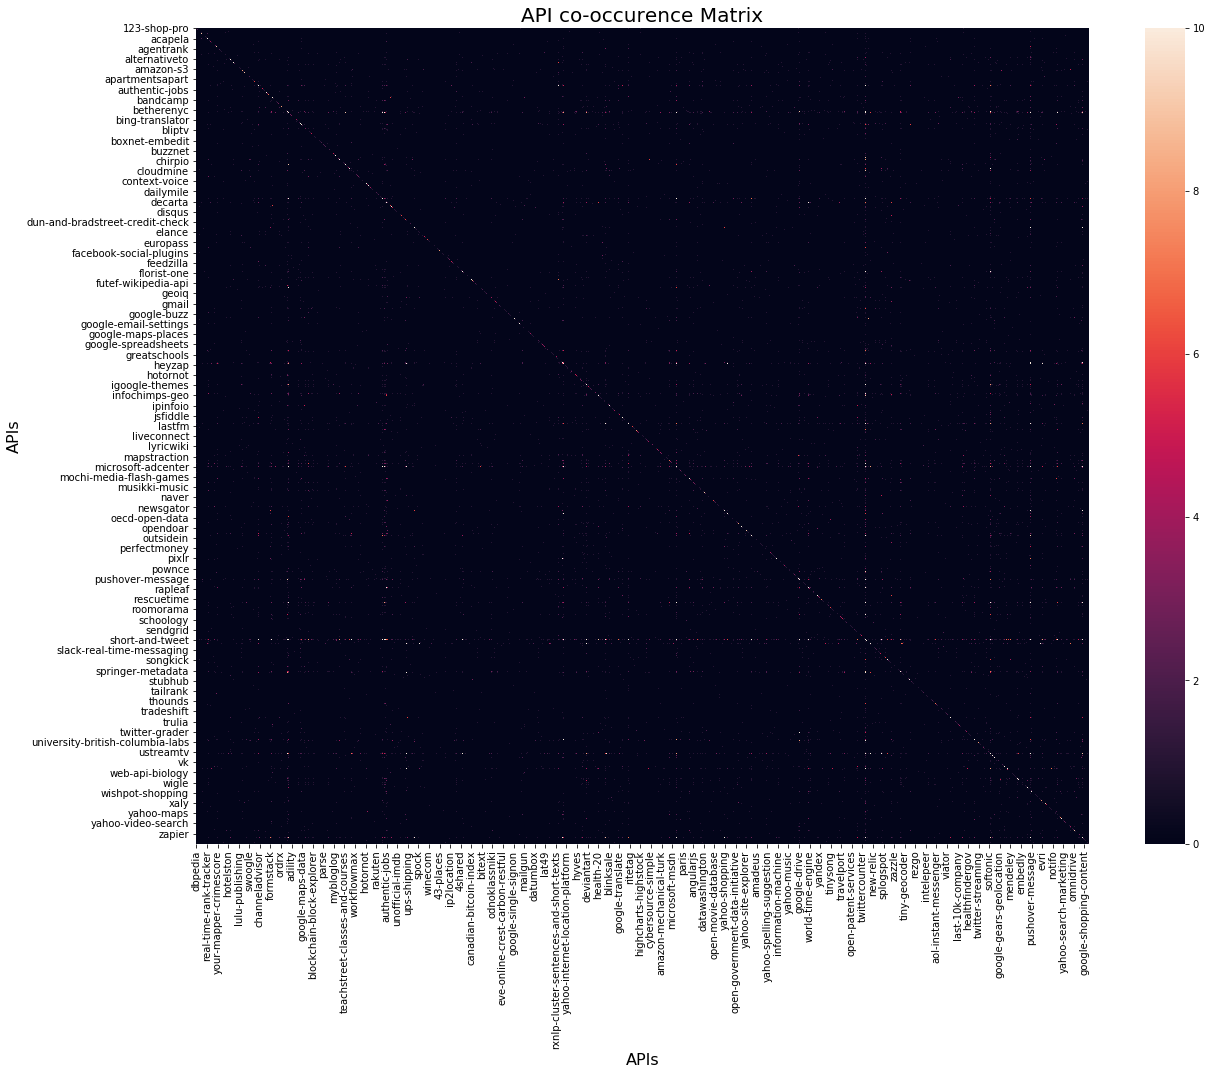

In [10]:



plt.figure(figsize=(20,15))
ax = sns.heatmap(A,vmin=0, vmax=10,cmap='rocket' )
ax.set_xlabel(xlabel='APIs', fontsize=16)
ax.set_ylabel(ylabel='APIs', fontsize=16)
ax.set_title(label='API co-occurence Matrix', fontsize=20)
plt.show()




##  The API - Mashup Matrix

Now let's have a look at the mashups and the APIs they use

Horizantal lines indicate that an API has been used to create a lot of mashups


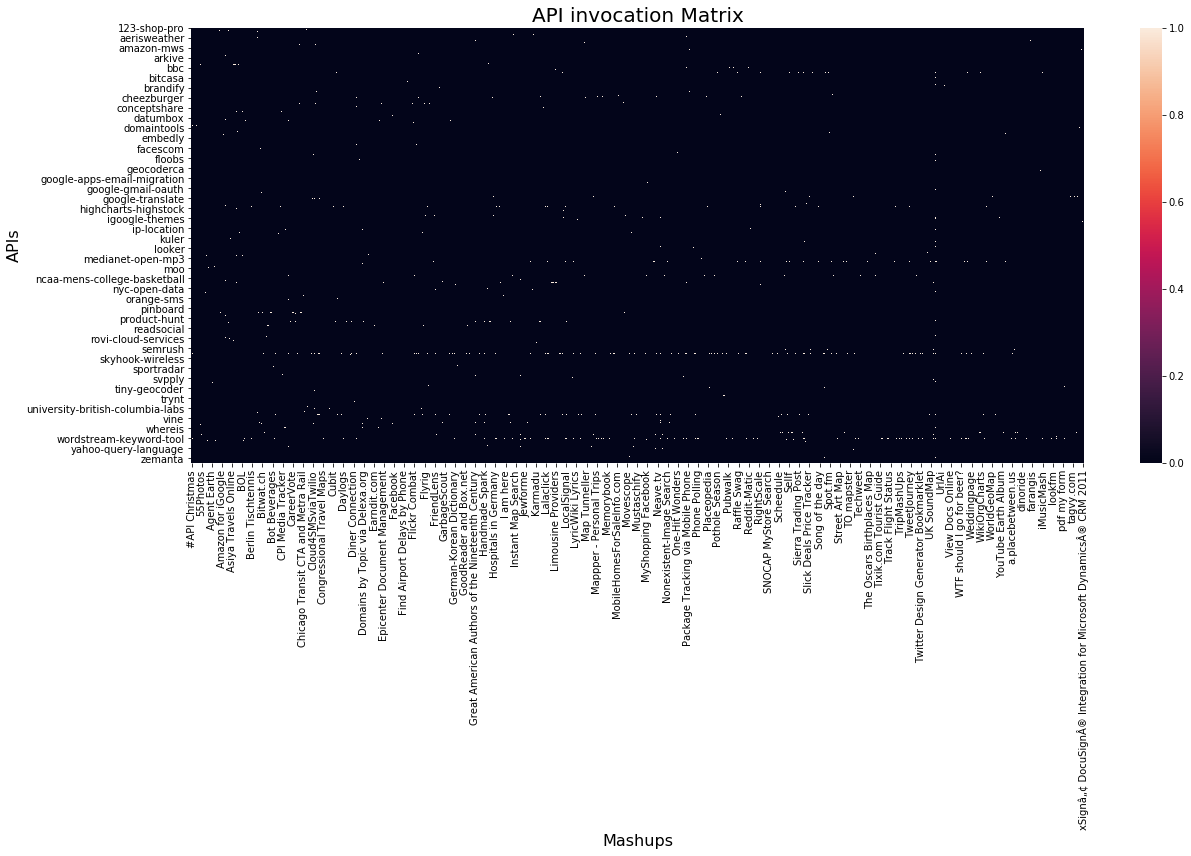

In [11]:


df = pd.DataFrame(ma_matrice.T,columns=mdata['title'].values)
df.index = u_apis['api_name'].values

plt.figure(figsize=(20,8))
ax = sns.heatmap(df,vmin=0, vmax=1,cmap='rocket' )
ax.set_xlabel(xlabel='Mashups', fontsize=16)
ax.set_ylabel(ylabel='APIs', fontsize=16)
ax.set_title(label='API invocation Matrix', fontsize=20)
plt.show()


# (10, 27)

# Recomendation Approach (Author Topic Model) 

The Programmable Web API recommendation problem can be defined as follow:
Given a list of Mashups and and their component APIs descriptions, build a recommender that returns a ranked list of APIs that would satisfy the user query. For the sake of off-line evaluation, the user query is represented by unseen mashup descriptions and categories

## Graphical explanation of the recomendation process

If you compare the description of the mashup Holidayen and its component service Flickr API in the picture below, you quickly notice that there is not much in common in their respective descriptions and that’s because each one serves a different function.
![Mashup_Api_Comparaison](img/macomp.png)
Holidayen helps users with planning their holidays and Flickr API provides access to photos from the Flickr platform using different feeds. To a mashup creator, it is clear that Flickr was used to provide adequate pictures for different locations and make the user experience pleasant, though this relation can not be captured by the service description because the API provider does not have to provide information about all the potential use cases of its services. The mashup descriptions on the other hand are more likely to give insight of the potential use cases of an API because they link the service Flickr to the ‘Travel’ use case in this example. 


Starting from this observation, the authors of [the reconstructed service profile paper](https://ieeexplore.ieee.org/document/7763869/) devised a way to build new API service description based on the description of the mashups that invoked said APIs. To put it more in context, let’s use the Holidayen example, the words used to describe the mashup can be attributed to each related API as shown in the figure below. Doing the stated operation for every mashup gives a new set of words to describe the APIs that better captures the relationship between the APIs and their use cases. The attribution of words from mashups to APIs is done using a generative probabilistic approach called The Author Topic model. 
![RSP](img/rsp.png)







The [author topic model model](https://arxiv.org/abs/1207.4169) was first introduced to explore the relationships between authors, documents, topics, and words in a collection of academics papers and paper abstracts. The author topic model views each words in a document as the manifestation of one of the authors’ interest (topics). According to the Author Topic Model,  to create each word w in a document d, an author is chosen at random from the uniform distribution of authors over document, and a word is picked from a topic distribution specific to that author. Accordingly, each author is associated with a multinomial distribution over topics, each topic is associated with a multinomial distribution over words,  and each word is associated with an author and a topic assignment. The topic distribution of a document is then a mixture of topic assignments of the author of the documents.


If each document was written by a unique author, then the author assignment becomes trivial, meaning that topics are determined by documents which is the same as using LDA model. 
Latent Dirichlet Allocation (LDA) is a generative statistical model that treats each document as a mixture of distinct topics (clusters of words) that are responsible for the appearance of each word in the document with a certain probability. The generative process to create mashups using LDA and the graph notation of LDA is presented below:

![LDA_Plate](img/LDA.png)


In the mashup service discovery context, we can think of APIs as being authors of mashup descriptions.  Each word in the description can then be attributed to one of the API’s topic assignment. the figure below depicts the plate notation of the generative process to mashup words creation with the author-topic model. 
The generative process to create mashups works as follows:

![ATM Plate](img/atm.png)

However; the recommendation approach I am using here is only needs the author assignment of the Author Topic Model, we use to calculate the following conditional probability. The probability can be seen as wether an API (s for Service) will satisfy a user if he inputs a word (w) in his query

\begin{equation} 
\label{eq:psw} p(s|w)=\frac {\text {RP}(s,w)}{\sum _{k}\text {RP}(k,w)}.
\end{equation} 

Once the relevance between services and words is calculated, the query relevance score can be defined as follow:

\begin{equation} r(s,Q)=\sum \limits _{w\in Q}p(s|w). \end{equation} 




To account for the popularity of APIs, a list of dominant words is generated by looking at the co-occurrences of service - word pairs . Basically, if a word in the reconstructed profiles is overwhelmingly associated with a service $p(s\vert w) ~=1$, the services and the words are associated and added to a dominant words list. If a dominant word is present in the user query, then its corresponding service score is boosted by adding the length of the query to the final relevance score. The authors [the reconstructed service profile paper](https://ieeexplore.ieee.org/document/7763869/) propose two simple rules to identify dominant words.

     p(s|w) > g where g is a constant between 0 and 1
     RP(s,w) > h where h is constant positive integer



### Functions for calculating relevance score

In [53]:
dominant_words = dict()
def rspsim(word,api,z,l):

    dist = (rsp[api][word])/z
    if(rsp[api][word] / z > 0.3 and rsp[api][word]>0.5):
        dist = (rsp[api][word]/z)+ l 
        if(word in dominant_words):
            if(not (api in dominant_words[word])):
                dominant_words[word].append(api)
        else:
            dominant_words[word]=[]
            dominant_words[word].append(api)
    
    return  dist



def get_rspsims(words,top_n=20):
    ranked_list = np.zeros(len(unique_apis),dtype='float')
    l = len(words)
    for word in words:
        
        z = np.sum(rsp[:,word])
        
        if(z > 0):
            sims = np.array([rspsim(word,api_id_dict[api],z,l) for api in unique_apis ])
        else:
            sims = np.zeros(len(unique_apis))
        ranked_list = ranked_list + sims
    
    
    df = pd.DataFrame(list(zip(unique_apis, list(ranked_list))), columns=['Author', 'Score'])
    return df


def recall(actual, predicted):
    la = len(actual)
    r = []

    for i in range(len(predicted)):
        tp = [doc for doc in predicted[:i+1] if doc in actual]
        r.append(len(tp) * 1.0 / la)

    return r


### Building Train and Test Set

In [13]:
rsp = np.zeros([len(unique_apis),len(features)])
rsp_dict = dict()
for each in unique_apis:
    rsp_dict[each] = []


            
            
most_common_5 = ['google-maps', 'twitter', 'youtube', 'flickr','facebook']
                  #,'amazon-product-advertising', 'twilio','lastfm', 'ebay', 'twilio-sms', 'google-search', 'microsoft-bing-maps', 
                  #'delicious-0', 'google-ajax-search', 'foursquare', 'google-app-engine', 
                  #'google-homepage', 'yahoo-search', 'docusign-enterprise', 'yahoo-maps']


from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train, Y_Test,dict_train,dict_test = train_test_split(corpus_encoded, rapis,dict_mashup_apis, test_size = 0.2, random_state = 0)

print('Size of train records:', len(X_Train))
print('Size of test records:', len(X_Test))
 


Size of train records: 5569
Size of test records: 1393


### Running the Author Topic Model
 may take some time

In [14]:
n_doc = len(X_Train)
n_topic = 50
n_author = len(unique_apis)
n_voca = len(features)
max_iter = 50
from original import AuthorTopicModel
model = AuthorTopicModel(n_doc, n_voca, n_topic, n_author,alpha = 1, beta=0.01)
model.fit(X_Train, dict_train, max_iter=max_iter)

2019-01-15 22:58:49 INFO:AuthorTopicModel:[INIT] 0	elapsed_time:3.99	log_likelihood:-838253.11
2019-01-15 22:58:53 INFO:AuthorTopicModel:[INIT] 1	elapsed_time:4.01	log_likelihood:-787336.21
2019-01-15 22:58:57 INFO:AuthorTopicModel:[INIT] 2	elapsed_time:4.10	log_likelihood:-752339.28
2019-01-15 22:59:02 INFO:AuthorTopicModel:[INIT] 3	elapsed_time:4.44	log_likelihood:-722000.62
2019-01-15 22:59:06 INFO:AuthorTopicModel:[INIT] 4	elapsed_time:3.89	log_likelihood:-691782.39
2019-01-15 22:59:10 INFO:AuthorTopicModel:[INIT] 5	elapsed_time:4.24	log_likelihood:-670841.14
2019-01-15 22:59:14 INFO:AuthorTopicModel:[INIT] 6	elapsed_time:3.90	log_likelihood:-655963.12
2019-01-15 22:59:18 INFO:AuthorTopicModel:[INIT] 7	elapsed_time:4.07	log_likelihood:-644816.54
2019-01-15 22:59:22 INFO:AuthorTopicModel:[INIT] 8	elapsed_time:4.16	log_likelihood:-636290.41
2019-01-15 22:59:26 INFO:AuthorTopicModel:[INIT] 9	elapsed_time:4.24	log_likelihood:-630723.53
2019-01-15 22:59:30 INFO:AuthorTopicModel:[INIT] 1

### Building Reconstructed  API description 

In [15]:

authors_assignment = model.author_assigned
   
#Building the Reconstructed Service Profile from the author assignment
for i in range(len(X_Train)):
    for j in range(len(X_Train[i])):
        rsp[authors_assignment[i][j]][X_Train[i][j]] = rsp[authors_assignment[i][j]][X_Train[i][j]] + 1
        if(not word_id_dict_reverse[X_Train[i][j]] in rsp_dict[api_id_dict_reverse[authors_assignment[i][j]]]):
            rsp_dict[api_id_dict_reverse[authors_assignment[i][j]]].append(word_id_dict_reverse[X_Train[i][j]])
        


### Getting the predictions

In [16]:
pred_most_common =[]
pred_atm_dw = []
lists = []
for test in X_Test:
    pred_most_common.append(most_common_5)
    df1= get_rspsims(test,5)      
    df = df1.sort_values('Score', ascending=False)[:5]
    pred_atm_dw.append(list(df['Author'].values))


### Result Evaluation MAP@5 and Recall@5

The most common apis is a good comparaison baseline as the most common APIs account for most of the API invocations. 

We see that the reconstructed profile approach is outperforming the baseline ^^

,RSP,Most_Common
MAP@5,0.523248,0.307253
R@5,0.549479,0.322442


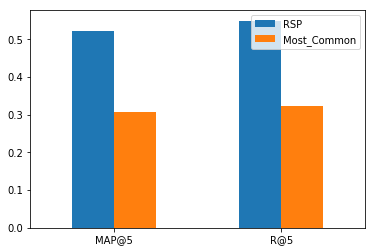

In [55]:
results_map_most_common = (metrics.mapk(Y_Test,pred_most_common,5))
results_map_atm_dw = (metrics.mapk(Y_Test,pred_atm_dw,5))

results_recall_atm_dw = np.mean([recall(a,p) for (a,p) in zip(Y_Test,pred_atm_dw)] )
results_recall_most_common = np.mean([recall(a,p) for (a,p) in zip(Y_Test,pred_most_common)] )

results_df= pd.DataFrame([[results_map_atm_dw,results_map_most_common],
                          [results_recall_atm_dw,results_recall_most_common]]
                         ,columns=['RSP','Most_Common'])
results_df.index = ['MAP@5','R@5']

results_df.plot(kind='bar',rot=0)

results_df.head()

### Let's have a look at the new descrption of APIs

In [52]:
keys  = []
values = []
for key,value in rsp_dict.items():
    if(value!=[]):
        keys.append(key)
        values.append(' '.join(value))

rsp_df= pd.DataFrame(keys,columns=['API'])
rsp_df['rsp_description'] = values
rsp_df

,API,rsp_description
0,12secondstv,desktop aggreg
1,18amail,kind paint parent famili member
2,1map,order
3,23,mashup book host
4,30-boxes,techniqu ad list 30 box calendar
5,3dcart,import xml txt support shop databas entiti pro...
6,411sync,latest advisori cell phone real time use wap c...
7,43-places,packag book custom solut button
8,43things,excit holiday onlin offer
9,7digital,guess artist song clip pictur question randoml...


# Thank you for following 

I hope this was helpful, feel free to get in contact for more information and please share any suggestions/comments you have ^^

#### Sources

The author topic model implementation was found in this [git](https://github.com/dongwookim-ml/python-topic-model)